In [36]:
import os 
import glob
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# 결측치 확인용
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc

#폰트 경로
font_path = "C:/Windows/Fonts/gulim.ttc"
 
#폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()
 
#font 설정
rc('font',family=font_name)


In [37]:
import re
p = re.compile('[0-9]+')

# 데이터가 있는 경로의 파일명 리스트 
BASE_DIR = os.path.dirname(os.path.abspath('.')) + "\\data\\PostCorona\\도로공사수도권교통량\\"
filenames = os.listdir(BASE_DIR)

# 확장자별로 담을 리스트 생성
txts = []
csvs = []

# 1. 파일명이 숫자인것만 분류
for i in range( len((os.listdir(BASE_DIR))) ):
    if p.match(filenames[i]):
# 2. txt파일들은 컬럼명이 없어서 read_csv할때의 코드가 다르므로 따로 분류
        if filenames[i].split('.')[1] == "txt":
            print(filenames[i],'는 txts리스트에 저장')
            txts.append(filenames[i]) # 201801~201911.txt 총 23건
        if filenames[i].split('.')[1] == "csv":
            print(filenames[i],'는 csvs리스트에 저장')
            csvs.append(filenames[i]) # 201912~202006.csv 총 7건
        
    else:
        print( '숫자로 시작하지 않는 "{}"파일은 저장 리스트에 담지 않음:'.format(filenames[i]) )

201801.txt 는 txts리스트에 저장
201802.txt 는 txts리스트에 저장
201803.txt 는 txts리스트에 저장
201804.txt 는 txts리스트에 저장
201805.txt 는 txts리스트에 저장
201806.txt 는 txts리스트에 저장
201807.txt 는 txts리스트에 저장
201808.txt 는 txts리스트에 저장
201809.txt 는 txts리스트에 저장
201810.txt 는 txts리스트에 저장
201811.txt 는 txts리스트에 저장
201812.txt 는 txts리스트에 저장
201901.txt 는 txts리스트에 저장
201902.txt 는 txts리스트에 저장
201903.txt 는 txts리스트에 저장
201904.txt 는 txts리스트에 저장
201905.txt 는 txts리스트에 저장
201906.txt 는 txts리스트에 저장
201907.txt 는 txts리스트에 저장
201908.txt 는 txts리스트에 저장
201909.txt 는 txts리스트에 저장
201910.txt 는 txts리스트에 저장
201911.txt 는 txts리스트에 저장
201912.csv 는 csvs리스트에 저장
202001.csv 는 csvs리스트에 저장
202002.csv 는 csvs리스트에 저장
202003.csv 는 csvs리스트에 저장
202004.csv 는 csvs리스트에 저장
202005.csv 는 csvs리스트에 저장
202006.csv 는 csvs리스트에 저장
숫자로 시작하지 않는 "Tollgate_201801_202006.csv"파일은 저장 리스트에 담지 않음:
숫자로 시작하지 않는 "수도권교통량데이터정보.txt"파일은 저장 리스트에 담지 않음:


In [38]:
txts = [pd.read_csv(BASE_DIR+txt, names=['집계일자', #'집계시',# 이 시점에는 시간별 통행량이 집계되지 않은것으로 사료됨
        '영업소코드', '입출구구분코드', 'TCS하이패스구분코드', '1종교통량', '2종교통량', '3종교통량', '4종교통량', '5종교통량', '6종교통량', '총교통량', 'Unnamed: 12'],
        sep="|") for txt in txts]

csvs = [pd.read_csv(BASE_DIR+csv, encoding = 'CP949') 
       for csv in csvs]

print("201801~201911 총 23건 확인 ->", len(txts)) 
print("201912~202006 총 7건 확인 ->", len(csvs)) 

201801~201911 총 23건 확인 -> 23
201912~202006 총 7건 확인 -> 7


In [39]:
original = txts + csvs
original = pd.concat(original)
original.tail(1)

,집계일자,영업소코드,입출구구분코드,TCS하이패스구분코드,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량,총교통량,Unnamed: 12,집계시
17087,20200630,254,1,2,605,22,10,31,23,36,727,NaN,23.0


In [41]:
original.to_csv(BASE_DIR+"Tollgate_201801_202006.csv", index=False)
original = pd.read_csv(BASE_DIR+"Tollgate_201801_202006.csv")
original.head()

,집계일자,영업소코드,입출구구분코드,TCS하이패스구분코드,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량,총교통량,Unnamed: 12,집계시
0,20180101,101,0,1,18382,125,198,108,30,188,19031,NaN,NaN
1,20180101,101,0,2,62592,1020,6885,328,164,2457,73446,NaN,NaN
2,20180101,101,1,1,17755,183,379,159,28,1477,19981,NaN,NaN
3,20180101,101,1,2,62199,1137,7590,393,166,2287,73772,NaN,NaN
4,20180101,190,0,1,11621,103,192,118,25,81,12140,NaN,NaN


# 전처리
- 잘못된데이터 행 제거
- 시간컬럼 변환
- 집계시점의 시간 컬럼을 군집화하여 일간총합으로 통일

컬럼: 영업소코드 값: [101 190 253 254 651 685]
컬럼: 입출구구분코드 값: [0 1]
컬럼: TCS하이패스구분코드 값: [1 2]
컬럼: Unnamed: 12 값: [nan]


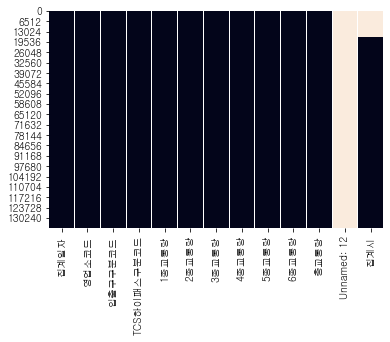

In [42]:
# 집계일자 및 교통량정보 제외하고 unique()확인
tmp = ['영업소코드', '입출구구분코드', 'TCS하이패스구분코드','Unnamed: 12']
for target_kindcol in tmp:
    print( "컬럼:",target_kindcol,"값:",original[target_kindcol].unique() )

# 결측치 확인
import seaborn as sns
sns.heatmap(original.isnull(), cbar=False )

# 결측치 제거
original.drop(['Unnamed: 12'], axis=1, inplace=True)
    
# 컬럼명 짧게 변경
original.rename(columns={"입출구구분코드":"입출구", "TCS하이패스구분코드":"하이패스"}, inplace=True)

In [43]:
def customIQR(dataframe, n=0.25):
    Q1 = dataframe.quantile(n)
    Q3 = dataframe.quantile(1-n)
    IQR = Q3 - Q1
    dataframe_out = dataframe[~( (dataframe < (Q1 - 1.5 * IQR)) |
                                 (dataframe > (Q3 + 1.5 * IQR)) ).any(axis=1)]
    return IQR, dataframe_out.shape
customIQR(original)


(집계일자     9270.00
 영업소코드     461.00
 입출구         1.00
 하이패스        1.00
 1종교통량    2324.00
 2종교통량      75.00
 3종교통량      78.00
 4종교통량      55.00
 5종교통량      61.00
 6종교통량     111.00
 총교통량     2682.00
 집계시        11.75
 dtype: float64,
 (104098, 12))

In [44]:
# 집계일자를 인덱스로 바꾸자 datetime으로 변경하고
original['집계일자'] = pd.to_datetime(original['집계일자'], format='%Y%m%d')
original['요일']     = original['집계일자'].apply(lambda x:x.weekday())

# 집계일자를 인덱스로 바꾸자 datetime으로 변경하고
original['집계일자'] = pd.to_datetime(original['집계일자'], format='%Y%m%d')
original['요일']     = original['집계일자'].apply(lambda x:x.weekday())

def weekend(x):
    if x == 5 or 6:
        x = "주말"
    else:
        x = "평일"
    return x

original['week'] = original['요일']
original['week'] = original['week'].apply(weekend)

# txt파일들은 "집계시" 컬럼이 없으므로 csv파일들의 집계시점을 날짜별로 합치고, 컬럼순서 조정한다
original = original.groupby(by=['집계일자', '영업소코드', '입출구', '하이패스', 'week'])[
    ['1종교통량', '2종교통량', '3종교통량', '4종교통량','5종교통량', '6종교통량', '총교통량']].sum().reset_index()
original = original[['집계일자','week','영업소코드','입출구','하이패스','총교통량','1종교통량','2종교통량','3종교통량','4종교통량','5종교통량','6종교통량']]

In [45]:
# def customIQR(dataframe, n=0.25, col='총교통량'):
#     Q1 = dataframe.quantile(n)
#     Q3 = dataframe.quantile(1-n)
#     IQR = Q3 - Q1
# #     dataframe_out = dataframe[~( (dataframe < (Q1 - 1.5 * IQR)) |
# #                                  (dataframe > (Q3 + 1.5 * IQR)) ).any(axis=1)]
#     tmp1 = dataframe[ (dataframe < (Q1 - 1.5 * IQR)).any(axis=1) ]
#     tmp2 = dataframe[ (dataframe > (Q3 + 1.5 * IQR)).any(axis=1) ][col].sort_values()

#     return tmp2

# for i in ['1종교통량', '2종교통량', '3종교통량', '4종교통량','5종교통량', '6종교통량', '총교통량']:
#     print(customIQR(original, 0.25, i))
# # df.reset_index( "집계일자")


## 서울발 교통량
- 서울101, 동서울190, 서서울253


#### 서울데이터에 대한 이상치 확인 및 제거
- 50k ~ 100k에 해당하는 분위 확인

In [49]:
df = original[ (original["영업소코드"]==101) |
               (original["영업소코드"]==190) |
               (original["영업소코드"]==253) ]
df = df.reset_index()

In [50]:

data           = df
target_kindcol = "영업소코드"
target_kinds   = [101, 190, 253]
target_bincol  = "6종교통량"
target_gbcol   = ["집계일자","영업소코드","입출구"]

traces = []
traces_all = pd.DataFrame()
for i in range(len(target_kinds)):
    trace = "trace0"
    trace = trace + str(i)
    traces.append(trace)
    traces[i] = data[data[target_kindcol]==target_kinds[i]].groupby(target_gbcol).sum().reset_index()
    traces[i][target_kindcol] = target_kinds[i]
    if traces[i].empty == False:
        traces_all = pd.concat([traces_all, traces[i]])

fig = px.histogram(traces_all, 
                   x=target_bincol, 
#                    y="selng_cascnt", 
                   color=target_kindcol,
                   marginal="box", # or violin, rug
#                    hover_data=traces_all.columns
                  )
fig.show()

In [51]:
df.describe()

,index,영업소코드,입출구,하이패스,총교통량,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량
count,10920.000000,10920.000000,10920.000000,10920.000000,1.092000e+04,10920.000000,10920.000000,10920.000000,10920.000000,1.092000e+04,10920.000000
mean,10733.297802,181.291209,0.500000,1.500000,4.476793e+04,37149.061447,1266.394231,2459.823168,1088.790476,9.860964e+02,1817.763553
std,6195.719020,62.410766,0.500023,0.500023,3.929042e+04,27908.373650,1125.068391,2762.731188,719.614847,1.469277e+04,1330.370885
min,0.000000,101.000000,0.000000,1.000000,5.961000e+03,4946.000000,19.000000,8.000000,5.000000,0.000000e+00,42.000000
25%,5373.750000,101.000000,0.000000,1.000000,1.431100e+04,11622.000000,343.750000,787.000000,559.000000,1.760000e+02,475.500000
50%,10715.500000,190.000000,0.500000,1.500000,3.674650e+04,31447.000000,511.000000,1135.000000,903.000000,3.120000e+02,1577.000000
75%,16097.250000,253.000000,1.000000,2.000000,7.909175e+04,66595.000000,2624.000000,2754.750000,1715.000000,1.441000e+03,3064.250000
max,21463.000000,253.000000,1.000000,2.000000,2.424794e+06,852283.000000,3911.000000,11105.000000,29677.000000,1.533276e+06,6369.000000


#### 일단920 보다 큰것 제거

In [ ]:
# # 11건의 이상치 (2019-03-05 ~ 07) 이동평균데이터 전후 2일 확인
# df = df[
# #     (df["집계일자"]=="2019-03-03")|
# #     (df["집계일자"]=="2019-03-04")|
#     (df["집계일자"]=="2019-03-05")
# #     (df["집계일자"]=="2019-03-06")|
# #     (df["집계일자"]=="2019-03-07")|
# #     (df["집계일자"]=="2019-03-08")|
# #     (df["집계일자"]=="2019-03-09")
# ]
# df.head(40)


In [52]:
# 필요한것
# 평균보다 10배 이상 큰것들 이상치라 생각 하고 nan값 채워줌
def outlier(x):
    for i in range(0, len(df[x])):
        if df[x][i] > df[x].quantile(0.5)*10:
            df[x][i]=np.nan

In [53]:
# 함수 적용
outlier('총교통량')
outlier('1종교통량')
outlier('2종교통량')
outlier('3종교통량')
outlier('4종교통량')
outlier('5종교통량')
outlier('6종교통량')

for i in df.columns:
    df[i]=df[i].fillna(method = 'backfill')

In [54]:
for target_bincol in ['총교통량', '1종교통량','2종교통량', '3종교통량', '4종교통량', '5종교통량', '6종교통량']:
    data           = df
    target_kindcol = "영업소코드"
    target_kinds   = [101, 190, 253]
    target_bincol  = target_bincol
    target_gbcol   = ["집계일자","영업소코드","입출구"]

    traces = []
    traces_all = pd.DataFrame()
    for i in range(len(target_kinds)):
        trace = "trace0"
        trace = trace + str(i)
        traces.append(trace)
        traces[i] = data[data[target_kindcol]==target_kinds[i]].groupby(target_gbcol).sum().reset_index()
        traces[i][target_kindcol] = target_kinds[i]
        if traces[i].empty == False:
            traces_all = pd.concat([traces_all, traces[i]])

    fig = px.histogram(traces_all, 
                       x=target_bincol, 
    #                    y="selng_cascnt", 
                       color=target_kindcol,
                       marginal="box", # or violin, rug
    #                    hover_data=traces_all.columns
                      )
    fig.show()

In [ ]:
df[np.abs(df["총교통량"]-df["총교통량"].mean() <=0.0001*df["총교통량"].std())]

df[np.abs(df.Data-df.Data.mean()) <= (3*df.Data.std())]
# keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

df[~(np.abs(df.Data-df.Data.mean()) > (3*df.Data.std()))]
# or if you prefer the other way around

min_out = 0.0000000000000000001
max_out = 0.9999999999999999999999999999999999999
df[target_kindcol].quantile(min_out), df[target_kindcol].quantile(max_out)

df[ (df[target_kindcol] > df[target_kindcol].quantile(min_out)) |
    (df[target_kindcol] < df[target_kindcol].quantile(max_out)) ]


df_min = df[ (df[target_kindcol] < df[target_kindcol].quantile(min_out)) ]
df_max = df[ (df[target_kindcol] > df[target_kindcol].quantile(max_out)) ]
df_max

data           = df_max
target_kindcol = "영업소코드"
target_kinds   = [101, 190, 253]
target_bincol  = "총교통량"
target_gbcol   = ["집계일자","영업소코드","입출구"]

traces = []
traces_all = pd.DataFrame()
for i in range(len(target_kinds)):
    trace = "trace0"
    trace = trace + str(i)
    traces.append(trace)
    traces[i] = data[data[target_kindcol]==target_kinds[i]].groupby(target_gbcol).sum().reset_index()
    traces[i][target_kindcol] = target_kinds[i]
    if traces[i].empty == False:
        traces_all = pd.concat([traces_all, traces[i]])

fig = px.histogram(traces_all, 
                   x=target_bincol, 
#                    y="selng_cascnt", 
                   color=target_kindcol,
                   marginal="box", # or violin, rug
#                    hover_data=traces_all.columns
                  )
fig.show()

original.tail()

df = original[ (original["영업소코드"]==101) |
               (original["영업소코드"]==190) |
               (original["영업소코드"]==253) ]

## 이동평균

In [61]:
window = 30
agg = df.groupby(by=["집계일자","영업소코드","입출구"])[["1종교통량","6종교통량"]].sum().reset_index()
agg["1종교통량"] = agg["1종교통량"].rolling(window=window).mean()
agg["6종교통량"] = agg["6종교통량"].rolling(window=window).mean()
agg.tail()

,집계일자,영업소코드,입출구,1종교통량,6종교통량
5455,2020-06-30,101,1,78001.900000,3523.633333
5456,2020-06-30,190,0,77865.266667,3519.033333
5457,2020-06-30,190,1,77763.900000,3515.866667
5458,2020-06-30,253,0,77574.666667,3508.333333
5459,2020-06-30,253,1,77477.000000,3505.500000


In [76]:
colors = ['#835AF1', '#7FA6EE', '#B8F7D4']
colors = ['#A56CC1', '#A6ACEC', '#63F5EF']

fig = make_subplots(rows=1, cols=1, specs=[[{}]])
for i in agg.입출구.unique().tolist():
    tmp = agg[agg.입출구 == i]
    for j in agg.영업소코드.unique().tolist():
        tmp1 = tmp[tmp.영업소코드 == j]
        fig.add_trace(
            go.Scatter(
                x=tmp1["집계일자"], 
                y=tmp1["1종교통량"],
                name = "입출구 : {},영업소코드 : {}".format(i,j), 
                line = dict(color=colors[1], width=1.5, dash="dashdot"),
                mode = "lines"), row=1, col=1)

fig.show()

In [58]:
px.line(data_frame = agg, x="집계일자", y="6종교통량", color="영업소코드")

### 이동평균그래프의 이상치 확인
- 이상치 없이 분포가 있음 확인

In [65]:
fig = px.histogram(agg, x="1종교통량", 
#                    nbins=20
                  )
fig.show()